In [6]:
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import torch
import torch.nn as nn

# --- Configuration ---
SEED = 4
np.random.seed(SEED)

# --- 1. Data Preparation ---
def process_patient_data_for_lstm(df, subject_col='id', visit_col='time', code_col='visit_codes', label_col='labels',
                                  code_to_idx=None):
    """
    Transforms flat EHR dataframe into a list of (multi_hot_sequence, label) tuples.
    """
    # assert code_col in df.columns, f"Code column '{code_col}' not found in dataframe."
    assert label_col in df.columns, f"Label column '{label_col}' not found in dataframe."
    assert subject_col in df.columns, f"Subject column '{subject_col}' not found in dataframe."
    assert visit_col in df.columns, f"Visit column '{visit_col}' not found in dataframe."
    # 1. Identify Vocabulary Size (Max code index + 1)
    # MAP code values to indices

    if code_to_idx is None:
        vocab_size = df[code_col].nunique()+1
        code_to_idx = {code: idx for idx, code in enumerate(df[code_col].unique(), start=0)}
    else:
        vocab_size = len(code_to_idx)+1
    df[code_col] = df[code_col].map(code_to_idx) 
    
    # 2. Group by Patient ID
    patients = []
    # We assume the label is static per patient. 
    # If it varies per visit, we usually take the max (e.g. ever diagnosed) or the last.
    # Here we take the max label for the patient as the target.
    for pid, group in df.groupby(subject_col):
        # Get patient label (assuming binary classification: 0 or 1)
        label = group[label_col].max() 
        # 3. Group by Time (Visit) to create sequence
        # Sort by time to ensure correct temporal order
        visits = group.sort_values(visit_col).groupby(visit_col)
        patient_seq = []
        for time_idx, visit_data in visits:
            # Create Multi-hot vector for this visit
            multi_hot = torch.zeros(vocab_size)
            codes = visit_data[code_col].values
            multi_hot[codes] = 1.0
            patient_seq.append(multi_hot)
        # Stack visits to create (seq_len, vocab_size) tensor
        patient_seq_tensor = torch.stack(patient_seq)
        patients.append((patient_seq_tensor, label))
        
    return patients, code_to_idx

# --- 2. Custom Dataset & Collate Function ---
def collate_fn(batch):
    """
    Custom collate function to pad variable-length visit sequences.
    """
    sequences, labels = zip(*batch)
    # Get original lengths for packing (needed for LSTM masking)
    lengths = torch.tensor([len(seq) for seq in sequences])
    # Pad sequences: (batch_size, max_seq_len, vocab_size)
    # batch_first=True ensures batch dimension is first
    padded_seqs = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded_seqs, lengths, labels

# --- 3. The Model (LSTM Classifier) ---
class EHR_LSTM_Classifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super().__init__()
        # 1. Visit Embedding
        # Projects the high-dim multi-hot vector (vocab_size) down to a dense embedding
        self.embedding = nn.Linear(vocab_size, embed_dim)
        # 2. LSTM Encoder
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # 3. Output Classifier
        self.fc = nn.Linear(hidden_dim, 1) # Binary classification output
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, lengths):
        # x shape: (batch_size, max_seq_len, vocab_size)
        # Create dense visit embeddings
        # shape: (batch_size, max_seq_len, embed_dim)
        x = self.embedding(x)
        self.feature_extract = x
        # Pack the sequence to ignore padding computation
        packed_x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # LSTM Forward
        # output contains all hidden states, (h_n, c_n) contains final states
        packed_output, (h_n, c_n) = self.lstm(packed_x)
        # Use the final hidden state of the last layer
        # h_n shape: (num_layers, batch_size, hidden_dim) -> take last layer
        final_encoding = h_n[-1]
        # Classification
        logits = self.fc(final_encoding)
        probs = self.sigmoid(logits)
        return probs.squeeze(-1)

class EHRDataset(torch.utils.data.Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]
    
def train_lstm_model(train_ehr, test_ehr, subject_col, visit_col, code_col, label_col,
                     embed_dim=32, hidden_dim=32, batch_size=32, epochs=5, verbose=True, seed=SEED):
    """
    Trains the LSTM classifier on the provided training data.
    """
    torch.manual_seed(seed)
    all_codes = set()
    all_codes.update(train_ehr[code_col].unique().tolist())
    all_codes.update(test_ehr[code_col].unique().tolist())
    code_to_idx = {code: idx for idx, code in enumerate(all_codes, start=1)} # start from 1 to reserve 0 for padding

    train_data, _ = process_patient_data_for_lstm(train_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col, code_to_idx=code_to_idx)
    test_data, _ = process_patient_data_for_lstm(test_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col, code_to_idx=code_to_idx)
    train_dataloader = torch.utils.data.DataLoader(dataset=EHRDataset(train_data), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(dataset=EHRDataset(test_data), batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
    
    model = EHR_LSTM_Classifier(vocab_size=len(code_to_idx)+1, embed_dim=embed_dim, hidden_dim=hidden_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_lens, batch_y in train_dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(batch_x, batch_lens)
            
            # Loss calculation
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_lens, batch_y in test_dataloader:
            predictions = model(batch_x, batch_lens)
            all_preds.extend(predictions.numpy())
            all_labels.extend(batch_y.numpy())
    # Calculate accuracy
    all_labels = np.array(all_labels)
    all_preds_binary = np.array([1 if p >= 0.5 else 0 for p in all_preds])
    accuracy = metrics.accuracy_score(all_labels, all_preds_binary)
    # print(f"Test Accuracy: {accuracy:.4f}")

    # bootstrapped accuracy and std
    bootstrap_inds = np.random.randint(0, len(all_preds_binary), size=(100, len(all_preds_binary)))
    bootstrap_accs = [metrics.accuracy_score(all_labels[bootstrap_inds[i]], all_preds_binary[bootstrap_inds[i]]) for i in range(len(bootstrap_inds))]
    accuracy = np.mean(bootstrap_accs)
    accuracy_std = np.std(bootstrap_accs)
    print(f"{accuracy=}, {accuracy_std=}")


    return model, accuracy

def aggregate_patient_visits(df, subject_col, code_col, label_col, code_to_idx):
    # assume codes are already integer encoded from 0 to N-1
    patient_vectors = []
    patient_labels = []
    for pid, group in df.groupby(subject_col):
        codes = group[code_col].unique()
        multi_hot = np.zeros(len(code_to_idx)+1)
        multi_hot[codes] = 1
        label = group[label_col].max() # Assuming static label per patient
        patient_vectors.append(multi_hot)
        patient_labels.append(label)
    patient_vectors = np.array(patient_vectors)
    patient_labels = np.array(patient_labels)
    return patient_vectors, patient_labels

def train_sklearn_model(train_ehr, test_ehr, subject_col, visit_col, code_col, label_col, model='rf'):
    """
    Trains a simple Logistic Regression model on flattened visit data.
    Each patient's visits are aggregated into a single multi-hot vector.
    """
    # 1. Aggregate visits into single multi-hot vector per patient
    all_codes = set()
    all_codes.update(train_ehr[code_col].unique().tolist())
    all_codes.update(test_ehr[code_col].unique().tolist())
    code_to_idx = {code: idx for idx, code in enumerate(all_codes, start=1)} # start from 1 to reserve 0 for padding
    train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
    test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)    

    X_train, y_train = aggregate_patient_visits(train_ehr, subject_col, code_col, label_col, code_to_idx)
    X_test, y_test = aggregate_patient_visits(test_ehr, subject_col, code_col, label_col, code_to_idx)

    # 2. Train Logistic Regression
    if model == 'rf':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=100, random_state=SEED)
    else:
        raise NotImplementedError(f"Model '{model}' not implemented.")
    model.fit(X_train, y_train)

    # 3. Evaluate
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    # print(f"Test Accuracy (Logistic Regression): {accuracy:.4f}")
    return model, accuracy

## --- Privacy Metrics ---
def convert_visits_to_sets(df, subject_col='id', visit_col='time', code_col='visit_codes'):
    """
    Converts a flat DataFrame into the required list of dicts format.

    Args:
        df (pd.DataFrame): Input dataframe with sequential event data. Eg. 
            pd.DataFrame({'visit_codes':[0,1, 3,4,1], 'labels':[0,0,0,0,1], 'time':[0,0,1,1, 0], 'id':[0,0,0,0,1]})
        subject_col (str): Column name for patient/subject identifiers.
        visit_col (str): Column name for visit/timestep identifiers.
        code_col (str): Column name for the multi-hot codes (e.g., diagnosis codes
    """
    records = df.groupby(subject_col)[[visit_col, code_col]].apply(
        lambda x: x.groupby(visit_col)[code_col].apply(set).tolist()
        ).tolist()

    return records

def calculate_hamming_distance_cutoff(v1, v2, cutoff):
    len1, len2 = len(v1), len(v2)
    dist = 0 if len1 == len2 else 1
    if dist >= cutoff:
        return cutoff

    min_len = min(len1, len2)

    for i in range(min_len):
        dist += len(v1[i] ^ v2[i])
        if dist >= cutoff:
            return cutoff

    if len1 > min_len:
        dist += sum(len(v) for v in v1[min_len:])
    elif len2 > min_len:
        dist += sum(len(v) for v in v2[min_len:])

    return dist

def find_nearest_neighbor_dist(query, reference_dataset):
    best = float('inf')
    for ref in reference_dataset:
        d = calculate_hamming_distance_cutoff(query, ref, best)
        if d == 0:
            return 0
        if d < best:
            best = d
    return best


def calc_nnaar(train_ehr, test_ehr, syn_ehr, subject_col, visit_col, code_col, label_col, sample_size=1000, verbose=False):
    """
    Calculates Nearest Neighbor Adversarial Accuracy Risk (NNAAR). 
    Measures if synthetic data is closer to training data than held-out test data.    
    NNAAR = AA_ES - AA_TS
    where AA_ES is Adversarial Accuracy between Test and Synthetic
          AA_TS is Adversarial Accuracy between Train and Synthetic
    """
    print(f"\n--- Calculating NNAAR (Sample Size: {sample_size}) ---")
    train = convert_visits_to_sets(train_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col)
    test = convert_visits_to_sets(test_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col)
    synthetic = convert_visits_to_sets(syn_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col)


    sample_size = min(sample_size, len(train), len(test), len(synthetic))
    s_train_inds = np.random.choice(np.arange(len(train)), sample_size, replace=False) if len(train) > sample_size else np.arange(len(train))
    s_train_subset = [train[i] for i in s_train_inds]
    s_test_inds = np.random.choice(np.arange(len(test)), sample_size, replace=False) if len(test) > sample_size else np.arange(len(test))
    s_test_subset = [test[i] for i in s_test_inds]
    s_syn_inds = np.random.choice(np.arange(len(synthetic)), sample_size, replace=False) if len(synthetic) > sample_size else np.arange(len(synthetic))
    s_syn_subset = [synthetic[i] for i in s_syn_inds]

    # AA_ES (Test vs Synthetic)
    val1 = sum(1 for p in tqdm(s_test_subset, desc="Test vs Syn", disable=not verbose) 
               if find_nearest_neighbor_dist(p, s_syn_subset) > find_nearest_neighbor_dist(p, s_test_subset))
    val2 = sum(1 for p in tqdm(s_syn_subset, desc="Syn vs Test", disable=not verbose) 
               if find_nearest_neighbor_dist(p, s_test_subset) > find_nearest_neighbor_dist(p, s_syn_subset))

    # AA_TS (Train vs Synthetic)
    val3 = sum(1 for p in tqdm(s_train_subset, desc="Train vs Syn", disable=not verbose) 
               if find_nearest_neighbor_dist(p, s_syn_subset) > find_nearest_neighbor_dist(p, s_train_subset))
    val4 = sum(1 for p in tqdm(s_syn_subset, desc="Syn vs Train", disable=not verbose) 
               if find_nearest_neighbor_dist(p, s_train_subset) > find_nearest_neighbor_dist(p, s_syn_subset))

    aa_es = 0.5 * (val1 / sample_size + val2 / sample_size)
    aa_ts = 0.5 * (val3 / sample_size + val4 / sample_size)
    
    score = aa_es - aa_ts
    # print(f"NNAAR Score: {score:.4f} (Target < 0.03)")
    return {'nnaar': score, 'aa_es': aa_es, 'aa_ts': aa_ts}

def calc_membership_inference(train_ehr, test_ehr, syn_ehr, subject_col, visit_col, code_col, label_col, num_attack_samples=1000, verbose=False):
    """
    Calculates Membership Inference Attack (Dataset Attack) metrics.
    Attempts to distinguish Members (Train) from Non-Members (Test) based on 
    proximity to Synthetic data.
    """
    print(f"\n--- Calculating Membership Inference (Attack Size: {num_attack_samples}) ---")
    train = convert_visits_to_sets(train_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col)
    test = convert_visits_to_sets(test_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col)
    synthetic = convert_visits_to_sets(syn_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col)
    # 1. Construct Attack Dataset (50% Members, 50% Non-Members)
    n_half = min(len(train), len(test), num_attack_samples) // 2
    
    # Members (Label 1)
    pos_samples_inds = np.random.choice(np.arange(len(train)), n_half, replace=False)
    pos_samples = [train[i] for i in pos_samples_inds]
    pos_labels = [1] * len(pos_samples)
    
    # Non-Members (Label 0)
    neg_samples_inds = np.random.choice(np.arange(len(test)), n_half, replace=False)
    neg_samples = [test[i] for i in neg_samples_inds]
    neg_labels = [0] * len(neg_samples)
    
    attack_data = pos_samples + neg_samples
    attack_labels = pos_labels + neg_labels
    
    # 2. Calculate distances to Synthetic dataset
    distances = []
    print("Computing distances to synthetic dataset...")
    for record in tqdm(attack_data, desc="Calculating Distances", disable=not verbose):
        dist = find_nearest_neighbor_dist(record, synthetic)
        distances.append(dist)

    # 3. Attack Logic: Thresholding
    # Logic: Real training records (members) are expected to be closer (lower distance) 
    # to synthetic records than non-members.
    median_dist = np.median(distances)
    predictions = [1 if d < median_dist else 0 for d in distances]
    
    # 4. Metrics
    results = {
        "MIA_F1": metrics.f1_score(attack_labels, predictions),
        "MIA_Precision": metrics.precision_score(attack_labels, predictions),
        "MIA_Recall": metrics.recall_score(attack_labels, predictions),
        "MIA_Accuracy": metrics.accuracy_score(attack_labels, predictions),
    }
    
    print("MIA Results:", results)
    return results

def compute_mle(train_fn, train_ehr, test_ehr, syn_ehr, subject_col, visit_col, code_col, label_col, **kwargs):
    """
    Computes Machine Learning Efficacy (Utility).
    Compares models trained on Real vs. Synthetic data, evaluated on Real data.
    """
    print("--- Computing MLE (Utility) ---")
    
    # 1. Train on Real, Test on Real (TRTR)
    print("Training on Real Data...")
    _, real_acc = train_fn(copy.deepcopy(train_ehr), copy.deepcopy(test_ehr), subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col, **kwargs)
    
    # 2. Train on Synthetic, Test on Real (TSTR)
    print("Training on Synthetic Data...")
    _, syn_acc = train_fn(copy.deepcopy(syn_ehr), copy.deepcopy(test_ehr), subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col, **kwargs)
    
    results = {
        "MLE_Real_Accuracy": real_acc,
        "MLE_Synth_Accuracy": syn_acc,
        "MLE_Difference": real_acc - syn_acc,  # Closer to 0 is better (usually)
        "MLE_Ratio": syn_acc/real_acc  # Closer to 0 is better (usually)
                
    }
    print(f"MLE Results: Real Acc: {real_acc:.4f}, Synth Acc: {syn_acc:.4f}, Diff: {real_acc - syn_acc:.4f}")
    return results

def compute_discriminator_privacy(train_fn, train_ehr, test_ehr, syn_ehr, subject_col, visit_col, code_col, label_col, **kwargs):
    """
    Computes ML Privacy via a Discriminator Model (Adversarial Accuracy).
    Attempts to predict if a record is Real (1) or Synthetic (0).
    
    Ideal Result: Accuracy ~ 0.5 (Indistinguishable)
    Bad Result: Accuracy >> 0.5 (Easy to distinguish)
    """
    print("\n--- Computing ML Privacy (Discriminator) ---")
    
    # 1. Label Data: Real = 1, Synthetic = 0
    real_df = copy.deepcopy(train_ehr)
    syn_df = copy.deepcopy(syn_ehr)

    # We create a new column for the discriminator label
    disc_label = "is_real"
    real_df[disc_label] = 1
    syn_df[disc_label] = 0
    
    # Ensure subject IDs don't clash when merging
    real_df[subject_col] = real_df[subject_col].astype(str) + "_real"
    syn_df[subject_col] = syn_df[subject_col].astype(str) + "_syn"
    
    # 2. Combine and Split
    # We need a mixed train set and a mixed test set to evaluate the discriminator
    combined_df = pd.concat([real_df, syn_df])
    
    # Get unique patients to split by patient, not by visit
    unique_patients = combined_df[subject_col].unique()
    train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=SEED)
    
    disc_train = combined_df[combined_df[subject_col].isin(train_ids)]
    disc_test = combined_df[combined_df[subject_col].isin(test_ids)]
    
    # 3. Train Discriminator
    # We pass 'disc_label' (is_real) as the target column instead of the original disease label
    print("Training Discriminator Model...")
    print(f"Discriminator Train Size: {len(disc_train)}, Test Size: {len(disc_test)}")
    _, acc = train_fn(
        train_ehr=disc_train,
        test_ehr=disc_test,
        subject_col=subject_col,
        visit_col=visit_col,
        code_col=code_col,
        label_col=disc_label, # Override target to be the Real/Fake label
        **kwargs
    )
    
    results = {
        "Privacy_Discriminator_Accuracy": acc,
        "Privacy_Score": 1.0 - 2 * abs(0.5 - acc) # Normalize: 1.0 is perfect privacy (0.5 acc), 0.0 is no privacy
    }
    print(f"Discriminator Accuracy: {acc:.4f}, Privacy Score: {results['Privacy_Score']:.4f}")
    return results

def compute_prevalence_metrics(train_ehr, syn_ehr, subject_col, code_col):
    """
    Computes statistical similarity of code prevalence between Real (Train) and Synthetic data.
    Calculates Patient-Level Prevalence: % of unique patients who have a specific code.
    """
    print("--- Computing Prevalence Metrics ---")
    
    # 1. Total unique patients
    all_codes = set()
    all_codes.update(train_ehr[code_col].unique().tolist())
    all_codes.update(syn_ehr[code_col].unique().tolist())
    
    n_train = train_ehr[subject_col].nunique()
    n_syn = syn_ehr[subject_col].nunique()
    
    if n_train == 0 or n_syn == 0:
        return {"Prevalence_R2": 0, "Prevalence_Pearson": 0, "Prevalence_RMSE": 0}

    # 2. Compute patient counts per code
    # Group by code, count unique subjects
    train_counts = train_ehr.groupby(code_col)[subject_col].nunique()
    syn_counts = syn_ehr.groupby(code_col)[subject_col].nunique()

    # add missing codes with count 0
    for code in all_codes:
        if code not in train_counts.index:
            train_counts.loc[code] = 0
        if code not in syn_counts.index:
            syn_counts.loc[code] = 0

    # 3. Calculate Probabilities (Prevalence)
    train_probs = train_counts / n_train
    syn_probs = syn_counts / n_syn

    # 4. Align Vectors
    # Create a DataFrame to ensure we align codes correctly, filling missing with 0
    df_compare = pd.DataFrame({'real': train_probs, 'syn': syn_probs}).fillna(0)
    
    real_vec = df_compare['real'].values
    syn_vec = df_compare['syn'].values
    
    # 5. Compute Statistics
    # R^2 Score
    r2 = metrics.r2_score(real_vec, syn_vec)
    
    # Pearson Correlation
    rho, _ = pearsonr(real_vec, syn_vec)
        
    # RMSE
    rmse = np.sqrt(metrics.mean_squared_error(real_vec, syn_vec))
    
    results = {
        "Prevalence_R2": r2,
        "Prevalence_Pearson": rho,
        "Prevalence_RMSE": rmse
    }
    print(f"Prevalence R2: {r2:.4f}, RMSE: {rmse:.4f}")
    return results

def calculate_all_metrics(train_ehr, test_ehr, syn_ehr, 
                          subject_col='id', visit_col='time', code_col='visit_codes', label_col='labels', 
                          sample_size=1000, mode='lstm', 
                          lstm_params={}, sklearn_params={}, metrics='all'):
    # only mode 'lstm' and 'rf' are supported
    final_output = {}
    if metrics in ('all', 'privacy'):
        nnaar_results = calc_nnaar(train_ehr, test_ehr, syn_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col, sample_size=sample_size)
        mia_results = calc_membership_inference(train_ehr, test_ehr, syn_ehr, subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col, num_attack_samples=sample_size)
        final_output.update(nnaar_results)
        final_output.update(mia_results)
    if metrics in ('all', 'utility'):
        if mode == 'lstm':
            # mle_results = compute_mle(train_fn=train_lstm_model, train_ehr=train_ehr, test_ehr=test_ehr, syn_ehr=syn_ehr,
            #     subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col,
            #     embed_dim=lstm_params['embed_dim'], hidden_dim=lstm_params['hidden_dim'], batch_size=lstm_params['batch_size'], epochs=lstm_params['epochs'], verbose=False)
            mld_results = compute_discriminator_privacy(train_fn=train_lstm_model, train_ehr=train_ehr, test_ehr=test_ehr, syn_ehr=syn_ehr,
                subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col,
                embed_dim=lstm_params['embed_dim'], hidden_dim=lstm_params['hidden_dim'], batch_size=lstm_params['batch_size'], epochs=lstm_params['epochs'], verbose=False)
        else:
            # mle_results = compute_mle(train_fn=train_sklearn_model, train_ehr=train_ehr, test_ehr=test_ehr, syn_ehr=syn_ehr,
            #     subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col,
            #     model=sklearn_params.get('model', 'rf'))
            mld_results = compute_discriminator_privacy(train_fn=train_sklearn_model, train_ehr=train_ehr, test_ehr=test_ehr, syn_ehr=syn_ehr,
                subject_col=subject_col, visit_col=visit_col, code_col=code_col, label_col=label_col,
                model=sklearn_params.get('model', 'rf'))
        
        prevalence_results = compute_prevalence_metrics(train_ehr, syn_ehr, subject_col, code_col)

        # final_output.update(mle_results)
        final_output.update(mld_results)
        final_output.update(prevalence_results)
    
    return final_output

def convert_cols_to_multihot(df, code_col: str, visit_col: str, cat_cols: list[str], num_cols: list[str], bins_per_num: int = 5) -> pd.DataFrame:
    """
    Converts categorical columns and numeric columns into categories to be added to multi-hot encoding (per timestep)
    Args:
        df (pd.DataFrame): Input dataframe.
        code_col (str): Column name for the multi-hot codes (e.g., diagnosis codes).
        cat_cols (list[str]): List of categorical column names to be one-hot encoded.
        num_cols (list[str]): List of numeric column names to be binned and one-hot encoded.
    Returns:
        pd.DataFrame: DataFrame with additional "codes" per timestep.
    """
    df = df.copy()
    # Process categorical columns
    for col in cat_cols:
        df[col] = col + "_" + df[col].astype(str)
    
    # Process numeric columns
    for col in num_cols:
        # Create bins
        df[col + "_binned"] = pd.qcut(df[col], q=bins_per_num, duplicates='drop').astype(str)
        df[col + "_binned"] = col + "_" + df[col + "_binned"]
    
    # Combine all codes into a single column per visit
    def combine_codes(row):
        codes = [str(row[code_col])]
        for col in cat_cols:
            codes.append(str(row[col]))
        for col in num_cols:
            codes.append(str(row[col + "_binned"]))
        return ",".join(codes)
    
    df['combined_codes'] = df.apply(combine_codes, axis=1)
    return df

def test():
    # --- Main Execution ---
    # For demonstration, creating dummy lists so the script doesn't crash if run directly
    train_ehr=pd.DataFrame({'visit_codes':[0,1,3,4,1,2,0,3,2,4,1,0,2,3,4,1,0,2,3,4,1,0,2,3,4],
                            'labels':[0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0],
                            'time':[0,0,1,1,0,1,2,2,3,3,1,2,3,4,4,0,1,2,3,4,1,2,3,4,5],
                            'id':[0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]})
    train_ehr = train_ehr.astype({'visit_codes': str, 'labels': int, 'time': int, 'id': str})

    test_ehr=pd.DataFrame({'visit_codes':[1,2,0,3,4,2,1,0,3,4,1,2,3,0,4,2,1,3,0,4],
                        'labels':[0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1],
                        'time':[0,0,0,1,1,1,2,2,2,2,0,1,1,2,2,3,3,3,4,4],
                        'id':[0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2]})
    test_ehr = test_ehr.astype({'visit_codes': str, 'labels': int, 'time': int, 'id': str})
    syn_ehr=pd.DataFrame({'visit_codes':[2,3,1,4,0,2,3,1,0,4,1,2,3,4,0,2,1,3,4,0,2,1,3,4,0,1,2,3,4,0],
                        'labels':[0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1],
                        'time':[0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5],
                        'id':[0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2]})
    syn_ehr = syn_ehr.astype({'visit_codes': str, 'labels': int, 'time': int, 'id': str})

    final_output = calculate_all_metrics(train_ehr, test_ehr, syn_ehr, 
                            subject_col='id', visit_col='time', code_col='visit_codes', label_col='labels', 
                            sample_size=1000, mode='lstm',
                            lstm_params={'embed_dim':32, 'hidden_dim':32, 'batch_size':32, 'epochs':5, 'verbose':False})
    # pickle.dump(final_output, open("results/privacy_evaluation/combined_metrics.pkl", "wb"))
    print(f"Final Combined Results: {final_output=}")

In [7]:
test()


--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synthetic dataset...
MIA Results: {'MIA_F1': 1.0, 'MIA_Precision': 1.0, 'MIA_Recall': 1.0, 'MIA_Accuracy': 1.0}

--- Computing ML Privacy (Discriminator) ---
Training Discriminator Model...
Discriminator Train Size: 40, Test Size: 15


/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.49, accuracy_std=0.3315116890850155
Discriminator Accuracy: 0.4900, Privacy Score: 0.9800
--- Computing Prevalence Metrics ---
Prevalence R2: -0.2500, RMSE: 0.0894
Final Combined Results: final_output={'nnaar': 0.0, 'aa_es': 1.0, 'aa_ts': 1.0, 'MIA_F1': 1.0, 'MIA_Precision': 1.0, 'MIA_Recall': 1.0, 'MIA_Accuracy': 1.0, 'Privacy_Discriminator_Accuracy': 0.49, 'Privacy_Score': 0.98, 'Prevalence_R2': -0.25, 'Prevalence_Pearson': nan, 'Prevalence_RMSE': 0.08944271909999157}


/tmp/ipykernel_3020543/1831402187.py:486: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = pearsonr(real_vec, syn_vec)


In [8]:
import pandas as pd
import os
MIMIC_DATA_PATH = '/home/chufan2/github/ehr_syn_repro/'
train_patients_path = '/home/chufan2/github/ehr_syn_repro/data/train_patient_ids.txt'
test_patients_path = '/home/chufan2/github/ehr_syn_repro/data/test_patient_ids.txt'

admissions_df = pd.read_csv(MIMIC_DATA_PATH + 'ADMISSIONS.csv')
patients_df = pd.read_csv(MIMIC_DATA_PATH + 'PATIENTS.csv')
diagnoses_df = pd.read_csv(MIMIC_DATA_PATH + 'DIAGNOSES_ICD.csv')

print(f"Admissions shape: {admissions_df.shape}")
print(f"Patients shape: {patients_df.shape}")
print(f"Diagnoses shape: {diagnoses_df.shape}")

admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
patients_df['DOB'] = pd.to_datetime(patients_df['DOB'])
# Calculate age at first admission
first_admissions = admissions_df.loc[
    admissions_df.groupby('SUBJECT_ID')['ADMITTIME'].idxmin()
][['SUBJECT_ID', 'ADMITTIME']]

demo_df = pd.merge(
    patients_df[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']],
    first_admissions,
    on='SUBJECT_ID',
    how='inner'
)

demo_df['AGE'] = (demo_df['ADMITTIME'].dt.year - demo_df['DOB'].dt.year)
demo_df['AGE'] = demo_df['AGE'].apply(lambda x: 90 if x > 89 else x)

# Merge admissions with diagnoses
admissions_info = admissions_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']]
merged_df = pd.merge(
    admissions_info,
    diagnoses_df[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE',]],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='inner'
)

# Merge with demographics
final_df = pd.merge(
    merged_df,
    demo_df[['SUBJECT_ID', 'AGE', 'GENDER', 'EXPIRE_FLAG']],
    on='SUBJECT_ID',
    how='left'
)

# Sort chronologically
final_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME',], inplace=True)

# map all HADM_ID to sequential visit IDs per SUBJECT_ID, starting from 0
final_df["VISIT_ID"] = final_df.groupby("SUBJECT_ID")["HADM_ID"].transform(lambda x: pd.factorize(x)[0])

final_df['SUBJECT_ID'] = final_df['SUBJECT_ID'].astype(str)
final_df['HADM_ID'] = final_df['HADM_ID'].astype(float)
final_df['ICD9_CODE'] = final_df['ICD9_CODE'].astype(str)

# split by train and test
train_patient_ids = pd.read_csv(train_patients_path, header=None)[0].astype(str)
test_patients_ids = pd.read_csv(test_patients_path, header=None)[0].astype(str)
train_ehr = final_df[final_df['SUBJECT_ID'].isin(train_patient_ids)].reset_index(drop=True)
test_ehr = final_df[final_df['SUBJECT_ID'].isin(test_patients_ids)].reset_index(drop=True)
# # Top 10 ICD9 codes correlated with EXPIRE_FLAG: ['1560', '1965', '85225', '1986', '1972', 'V667', '1519', '2387', '07041', '73741']
# top_10_codes = ['1560', '1965', '85225', '1986', '1972', 'V667', '1519', '2387', '07041', '73741']

print(train_ehr.shape, test_ehr.shape)
print(train_ehr['SUBJECT_ID'].nunique(), test_ehr['SUBJECT_ID'].nunique())
print(train_ehr.groupby('SUBJECT_ID')['VISIT_ID'].nunique().max(), train_ehr.groupby('SUBJECT_ID')['VISIT_ID'].nunique().mean())
print(train_ehr['ICD9_CODE'].nunique(), test_ehr['ICD9_CODE'].nunique())

train_ehr_flattened = train_ehr.copy()
train_ehr_flattened['HADM_ID'] = 1
test_ehr_flattened = test_ehr.copy()
test_ehr_flattened['HADM_ID'] = 1

Admissions shape: (58976, 19)
Patients shape: (46520, 8)
Diagnoses shape: (651047, 5)
(637161, 8) (13886, 8)
45520 1000
42 1.2682117750439368
6956 1997


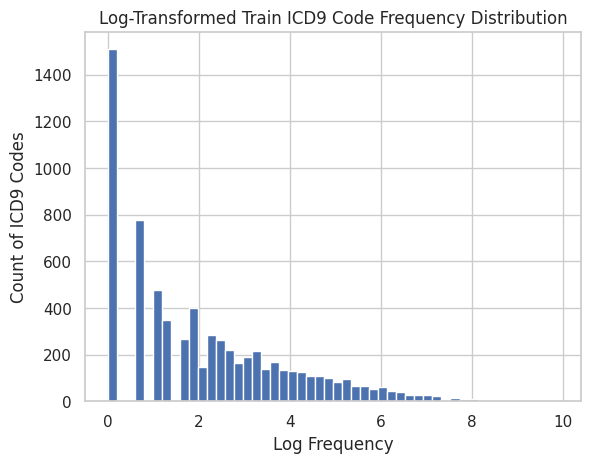

In [24]:
# make it log scale plot, make it sns
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
train_ehr['ICD9_CODE'].value_counts().apply(np.log).plot(
    kind='hist', bins=50,
    title='Log-Transformed Train ICD9 Code Frequency Distribution',
    xlabel='Log Frequency', ylabel='Count of ICD9 Codes')
plt.savefig('imgs/train_icd9_code_freq_distribution.pdf')

In [ ]:
long_tailed_ablation = True

base_path = '/home/chufan2/github/ehr_syn_repro/data/'
all_metrics = []
for path in [base_path+'synthetic_10k_halo.csv', base_path+'synthetic_10k_medgan.csv', base_path+'synthetic_10k_corgan.csv', base_path+'synthetic_10k_promptehr.csv',
             '/home/chufan2/github/ehr_syn_repro/synthetic_data/transformer_baseline/transformer_baseline_synthetic_ehr.csv']:
    
    # syn_ehr_path = base_path + path
    syn_ehr_df = pd.read_csv(path)
    if 'corgan' in os.path.basename(path) or 'medgan' in os.path.basename(path):
        syn_ehr_df['HADM_ID'] = 1
        mode = 'rf'
    else:
        mode = 'lstm'
    syn_ehr_df['EXPIRE_FLAG'] = 0  # dummy label column

    for percentile in [75, 90, 95, 97.5, 99]:

        # syn_ehr_df['EXPIRE_FLAG'] = syn_ehr_df['ICD9_CODE'].apply(lambda x: 1 if x in top_10_codes else 0)

        # calulate long_tailed bottom 75% codes prevalence
        train_ehr_copy = train_ehr.copy()
        test_ehr_copy = test_ehr.copy()
        syn_ehr_df_copy = syn_ehr_df.copy()
        if long_tailed_ablation:
            code_counts = train_ehr['ICD9_CODE'].value_counts()
            bottom_percentile_thresh = np.percentile(code_counts.values, percentile)
            bottom_percentile_codes = set(code_counts[code_counts <= bottom_percentile_thresh].index.tolist())

            # get percentage of codes in bottom half by raw count
            bottom_percentile_counts = code_counts[code_counts <= bottom_percentile_thresh].sum()
            total_counts = code_counts.sum()
            print(f"Bottom {percentile}% ICD9 codes account for {bottom_percentile_counts/total_counts*100:.2f}% of total code occurrences in training set.")
            print(len(bottom_percentile_codes), len(code_counts))


            syn_ehr_df_copy = syn_ehr_df_copy[syn_ehr_df_copy['ICD9_CODE'].isin(bottom_percentile_codes)].reset_index(drop=True)
            train_ehr_copy = train_ehr_copy[train_ehr_copy['ICD9_CODE'].isin(bottom_percentile_codes)].reset_index(drop=True)
            test_ehr_copy = test_ehr_copy[test_ehr_copy['ICD9_CODE'].isin(bottom_percentile_codes)].reset_index(drop=True)
        
        print(f"Synthetic EHR from {path}: {syn_ehr_df_copy.shape}")

        final_output = calculate_all_metrics(train_ehr_copy, test_ehr_copy, syn_ehr_df_copy, 
                                subject_col='SUBJECT_ID', visit_col='HADM_ID', code_col='ICD9_CODE', label_col='EXPIRE_FLAG', 
                                sample_size=1000, mode=mode,
                                lstm_params={'embed_dim':16, 'hidden_dim':16, 'batch_size':64, 'epochs':5, 'verbose':False})
        print(f"Final Combined Results for {path}: {final_output=}")

        final_output['method'] = os.path.basename(path).split('.')[0]
        final_output['long_tailed_percentile'] = percentile
        all_metrics.append(final_output)

        df = pd.DataFrame(all_metrics)

        if long_tailed_ablation:
            df.to_csv(f'./imgs/long_tailed_ablation.csv', index=False)


Bottom 75% ICD9 codes account for 5.06% of total code occurrences in training set.
5247 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: (4814, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synthetic dataset...
MIA Results: {'MIA_F1': 0.5054347826086957, 'MIA_Precision': 0.5166666666666667, 'MIA_Recall': 0.4946808510638298, 'MIA_Accuracy': 0.5159574468085106}

--- Computing ML Privacy (Discriminator) ---
Training Discriminator Model...
Discriminator Train Size: 29497, Test Size: 7529


/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.8184728701203043, accuracy_std=0.005583231356183493
Discriminator Accuracy: 0.8185, Privacy Score: 0.3631
--- Computing Prevalence Metrics ---
Prevalence R2: -0.1535, RMSE: 0.0004
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: final_output={'nnaar': -0.0026525198938992522, 'aa_es': 0.9350132625994695, 'aa_ts': 0.9376657824933687, 'MIA_F1': 0.5054347826086957, 'MIA_Precision': 0.5166666666666667, 'MIA_Recall': 0.4946808510638298, 'MIA_Accuracy': 0.5159574468085106, 'Privacy_Discriminator_Accuracy': 0.8184728701203043, 'Privacy_Score': 0.3630542597593913, 'Prevalence_R2': -0.15349561834737346, 'Prevalence_Pearson': 0.6028296004613194, 'Prevalence_RMSE': 0.00040399984511633}
Bottom 90% ICD9 codes account for 15.50% of total code occurrences in training set.
6262 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: (14094, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership I

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.8124389922173856, accuracy_std=0.00448875506163502
Discriminator Accuracy: 0.8124, Privacy Score: 0.3751
--- Computing Prevalence Metrics ---
Prevalence R2: 0.6272, RMSE: 0.0005
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: final_output={'nnaar': 0.009052924791086325, 'aa_es': 0.9415041782729805, 'aa_ts': 0.9324512534818942, 'MIA_F1': 0.48314606741573035, 'MIA_Precision': 0.48725212464589235, 'MIA_Recall': 0.479108635097493, 'MIA_Accuracy': 0.48746518105849584, 'Privacy_Discriminator_Accuracy': 0.8124389922173856, 'Privacy_Score': 0.37512201556522884, 'Prevalence_R2': 0.6271829217564883, 'Prevalence_Pearson': 0.8113729007554168, 'Prevalence_RMSE': 0.0004732292318168097}
Bottom 95% ICD9 codes account for 27.20% of total code occurrences in training set.
6608 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: (24326, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership In

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.8147137785666742, accuracy_std=0.0044662939993077855
Discriminator Accuracy: 0.8147, Privacy Score: 0.3706
--- Computing Prevalence Metrics ---
Prevalence R2: 0.7281, RMSE: 0.0007
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: final_output={'nnaar': 0.023838630806845895, 'aa_es': 0.9584352078239609, 'aa_ts': 0.934596577017115, 'MIA_F1': 0.5158924205378973, 'MIA_Precision': 0.5158924205378973, 'MIA_Recall': 0.5158924205378973, 'MIA_Accuracy': 0.5158924205378973, 'Privacy_Discriminator_Accuracy': 0.8147137785666742, 'Privacy_Score': 0.3705724428666517, 'Prevalence_R2': 0.7280713099974776, 'Prevalence_Pearson': 0.8727319565823171, 'Prevalence_RMSE': 0.0006841482020256663}
Bottom 97.5% ICD9 codes account for 40.45% of total code occurrences in training set.
6782 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: (36816, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership In

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.8093686617617816, accuracy_std=0.004393559220995191
Discriminator Accuracy: 0.8094, Privacy Score: 0.3813
--- Computing Prevalence Metrics ---
Prevalence R2: 0.7894, RMSE: 0.0009
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: final_output={'nnaar': 0.007709251101321701, 'aa_es': 0.9620044052863437, 'aa_ts': 0.954295154185022, 'MIA_F1': 0.5188470066518847, 'MIA_Precision': 0.5223214285714286, 'MIA_Recall': 0.5154185022026432, 'MIA_Accuracy': 0.5220264317180616, 'Privacy_Discriminator_Accuracy': 0.8093686617617816, 'Privacy_Score': 0.38126267647643686, 'Prevalence_R2': 0.7894454540995308, 'Prevalence_Pearson': 0.9109545926147402, 'Prevalence_RMSE': 0.0009280458752086777}
Bottom 99% ICD9 codes account for 57.14% of total code occurrences in training set.
6886 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: (53052, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Infe

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.8189531785306433, accuracy_std=0.0036635740610624205
Discriminator Accuracy: 0.8190, Privacy Score: 0.3621
--- Computing Prevalence Metrics ---
Prevalence R2: 0.8321, RMSE: 0.0013
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_halo.csv: final_output={'nnaar': 0.005832449628843994, 'aa_es': 0.9867444326617179, 'aa_ts': 0.9809119830328739, 'MIA_F1': 0.5145945945945946, 'MIA_Precision': 0.5242290748898678, 'MIA_Recall': 0.505307855626327, 'MIA_Accuracy': 0.5233545647558386, 'Privacy_Discriminator_Accuracy': 0.8189531785306433, 'Privacy_Score': 0.3620936429387134, 'Prevalence_R2': 0.8321249180860878, 'Prevalence_Pearson': 0.9404296964061803, 'Prevalence_RMSE': 0.0013264473215187738}
Bottom 75% ICD9 codes account for 5.06% of total code occurrences in training set.
5247 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: (2227, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Infe

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.9604, Privacy Score: 0.0791
--- Computing Prevalence Metrics ---
Prevalence R2: -32.0521, RMSE: 0.0022
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: final_output={'nnaar': 0.022546419098143256, 'aa_es': 0.9376657824933687, 'aa_ts': 0.9151193633952255, 'MIA_F1': 0.32452830188679244, 'MIA_Precision': 0.5584415584415584, 'MIA_Recall': 0.22872340425531915, 'MIA_Accuracy': 0.523936170212766, 'Privacy_Discriminator_Accuracy': 0.9604266067920292, 'Privacy_Score': 0.07914678641594164, 'Prevalence_R2': -32.052064224970906, 'Prevalence_Pearson': 0.5886480827648961, 'Prevalence_RMSE': 0.0021625816721315325}
Bottom 90% ICD9 codes account for 15.50% of total code occurrences in training set.
6262 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: (15203, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to s

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.9099, Privacy Score: 0.1803
--- Computing Prevalence Metrics ---
Prevalence R2: -6.0201, RMSE: 0.0021
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: final_output={'nnaar': 0.032729805013927527, 'aa_es': 0.9122562674094707, 'aa_ts': 0.8795264623955432, 'MIA_F1': 0.367003367003367, 'MIA_Precision': 0.46382978723404256, 'MIA_Recall': 0.30362116991643456, 'MIA_Accuracy': 0.4763231197771588, 'Privacy_Discriminator_Accuracy': 0.9098649442160892, 'Privacy_Score': 0.18027011156782158, 'Prevalence_R2': -6.020108896272695, 'Prevalence_Pearson': 0.8271567734157064, 'Prevalence_RMSE': 0.002053504168412895}
Bottom 95% ICD9 codes account for 27.20% of total code occurrences in training set.
6608 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: (28869, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synt

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.8842, Privacy Score: 0.2317
--- Computing Prevalence Metrics ---
Prevalence R2: -1.1433, RMSE: 0.0019
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: final_output={'nnaar': 0.03239608801955984, 'aa_es': 0.9144254278728606, 'aa_ts': 0.8820293398533008, 'MIA_F1': 0.5198019801980198, 'MIA_Precision': 0.5263157894736842, 'MIA_Recall': 0.5134474327628362, 'MIA_Accuracy': 0.5256723716381418, 'Privacy_Discriminator_Accuracy': 0.884160468235581, 'Privacy_Score': 0.23167906352883794, 'Prevalence_R2': -1.1432742640318119, 'Prevalence_Pearson': 0.885976062303713, 'Prevalence_RMSE': 0.0019207089020422529}
Bottom 97.5% ICD9 codes account for 40.45% of total code occurrences in training set.
6782 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: (45732, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synt

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.8490, Privacy Score: 0.3021
--- Computing Prevalence Metrics ---
Prevalence R2: 0.2910, RMSE: 0.0017
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: final_output={'nnaar': -0.0038546255506607396, 'aa_es': 0.9162995594713657, 'aa_ts': 0.9201541850220264, 'MIA_F1': 0.5022123893805309, 'MIA_Precision': 0.5044444444444445, 'MIA_Recall': 0.5, 'MIA_Accuracy': 0.5044052863436124, 'Privacy_Discriminator_Accuracy': 0.8489522391234975, 'Privacy_Score': 0.302095521753005, 'Prevalence_R2': 0.2910034994802051, 'Prevalence_Pearson': 0.9269277144116433, 'Prevalence_RMSE': 0.0017029785564164031}
Bottom 99% ICD9 codes account for 57.14% of total code occurrences in training set.
6886 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: (66837, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synthetic dataset...

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.8373, Privacy Score: 0.3253
--- Computing Prevalence Metrics ---
Prevalence R2: 0.7627, RMSE: 0.0016
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_medgan.csv: final_output={'nnaar': 0.008483563096500557, 'aa_es': 0.9485683987274656, 'aa_ts': 0.940084835630965, 'MIA_F1': 0.4956140350877193, 'MIA_Precision': 0.5124716553287982, 'MIA_Recall': 0.47983014861995754, 'MIA_Accuracy': 0.5116772823779193, 'Privacy_Discriminator_Accuracy': 0.8373272347618574, 'Privacy_Score': 0.3253455304762851, 'Prevalence_R2': 0.7626764181208786, 'Prevalence_Pearson': 0.9571503165454455, 'Prevalence_RMSE': 0.0015771294284403332}
Bottom 75% ICD9 codes account for 5.06% of total code occurrences in training set.
5247 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: (2599, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to syntheti

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.9375, Privacy Score: 0.1251
--- Computing Prevalence Metrics ---
Prevalence R2: -58.9712, RMSE: 0.0029
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: final_output={'nnaar': -0.021220159151193685, 'aa_es': 0.9323607427055702, 'aa_ts': 0.9535809018567639, 'MIA_F1': 0.21551724137931033, 'MIA_Precision': 0.5681818181818182, 'MIA_Recall': 0.13297872340425532, 'MIA_Accuracy': 0.5159574468085106, 'Privacy_Discriminator_Accuracy': 0.9374665954035275, 'Privacy_Score': 0.125066809192945, 'Prevalence_R2': -58.97122313334991, 'Prevalence_Pearson': 0.12022262786892916, 'Prevalence_RMSE': 0.00291302812212992}
Bottom 90% ICD9 codes account for 15.50% of total code occurrences in training set.
6262 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: (16395, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to syn

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.8854, Privacy Score: 0.2291
--- Computing Prevalence Metrics ---
Prevalence R2: -23.6577, RMSE: 0.0038
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: final_output={'nnaar': 0.020891364902507092, 'aa_es': 0.9512534818941505, 'aa_ts': 0.9303621169916434, 'MIA_F1': 0.24750499001996007, 'MIA_Precision': 0.43661971830985913, 'MIA_Recall': 0.17270194986072424, 'MIA_Accuracy': 0.47493036211699163, 'Privacy_Discriminator_Accuracy': 0.8854294687969412, 'Privacy_Score': 0.22914106240611765, 'Prevalence_R2': -23.657744673677865, 'Prevalence_Pearson': 0.28894904950929, 'Prevalence_RMSE': 0.0038485784161680914}
Bottom 95% ICD9 codes account for 27.20% of total code occurrences in training set.
6608 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: (33720, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to 

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.8982, Privacy Score: 0.2036
--- Computing Prevalence Metrics ---
Prevalence R2: -9.7561, RMSE: 0.0043
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: final_output={'nnaar': 0.01344743276283622, 'aa_es': 0.9663814180929096, 'aa_ts': 0.9529339853300733, 'MIA_F1': 0.48221343873517786, 'MIA_Precision': 0.5228571428571429, 'MIA_Recall': 0.4474327628361858, 'MIA_Accuracy': 0.519559902200489, 'Privacy_Discriminator_Accuracy': 0.8981941309255079, 'Privacy_Score': 0.20361173814898414, 'Prevalence_R2': -9.756120283233445, 'Prevalence_Pearson': 0.3700703773096833, 'Prevalence_RMSE': 0.004302793459435074}
Bottom 97.5% ICD9 codes account for 40.45% of total code occurrences in training set.
6782 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: (50527, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synt

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.9171, Privacy Score: 0.1657
--- Computing Prevalence Metrics ---
Prevalence R2: -4.0067, RMSE: 0.0045
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: final_output={'nnaar': -0.0011013215859031478, 'aa_es': 0.9757709251101321, 'aa_ts': 0.9768722466960352, 'MIA_F1': 0.5253664036076663, 'MIA_Precision': 0.5381062355658198, 'MIA_Recall': 0.513215859030837, 'MIA_Accuracy': 0.5363436123348018, 'Privacy_Discriminator_Accuracy': 0.9171265175077756, 'Privacy_Score': 0.16574696498444874, 'Prevalence_R2': -4.006684394430887, 'Prevalence_Pearson': 0.4331388509411391, 'Prevalence_RMSE': 0.004525454903800053}
Bottom 99% ICD9 codes account for 57.14% of total code occurrences in training set.
6886 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: (71395, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to synt

/tmp/ipykernel_3020543/1831402187.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ehr[code_col] = train_ehr[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ehr[code_col] = test_ehr[code_col].map(code_to_idx)


Discriminator Accuracy: 0.9335, Privacy Score: 0.1330
--- Computing Prevalence Metrics ---
Prevalence R2: -1.3432, RMSE: 0.0050
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_corgan.csv: final_output={'nnaar': 0.002651113467656341, 'aa_es': 0.9915164369034994, 'aa_ts': 0.9888653234358431, 'MIA_F1': 0.5224215246636771, 'MIA_Precision': 0.5534441805225653, 'MIA_Recall': 0.49469214437367304, 'MIA_Accuracy': 0.5477707006369427, 'Privacy_Discriminator_Accuracy': 0.9334798814871452, 'Privacy_Score': 0.13304023702570955, 'Prevalence_R2': -1.3431572412857502, 'Prevalence_Pearson': 0.5474401263316699, 'Prevalence_RMSE': 0.004955615528097366}
Bottom 75% ICD9 codes account for 5.06% of total code occurrences in training set.
5247 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: (1069, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Membership Inference (Attack Size: 1000) ---
Computing distances to sy

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.9391331865712715, accuracy_std=0.0040567553139284045
Discriminator Accuracy: 0.9391, Privacy Score: 0.1217
--- Computing Prevalence Metrics ---
Prevalence R2: -7.8257, RMSE: 0.0011
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: final_output={'nnaar': -0.01326259946949615, 'aa_es': 0.8620689655172413, 'aa_ts': 0.8753315649867375, 'MIA_F1': 0.19591836734693877, 'MIA_Precision': 0.42105263157894735, 'MIA_Recall': 0.1276595744680851, 'MIA_Accuracy': 0.47606382978723405, 'Privacy_Discriminator_Accuracy': 0.9391331865712715, 'Privacy_Score': 0.12173362685745692, 'Prevalence_R2': -7.825662604254752, 'Prevalence_Pearson': 0.4382055310102583, 'Prevalence_RMSE': 0.0011174983342440942}
Bottom 90% ICD9 codes account for 15.50% of total code occurrences in training set.
6262 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: (14930, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.821137336272857, accuracy_std=0.0047931952706917755
Discriminator Accuracy: 0.8211, Privacy Score: 0.3577
--- Computing Prevalence Metrics ---
Prevalence R2: 0.5687, RMSE: 0.0005
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: final_output={'nnaar': -0.007660167130919215, 'aa_es': 0.9317548746518106, 'aa_ts': 0.9394150417827298, 'MIA_F1': 0.42406015037593986, 'MIA_Precision': 0.46078431372549017, 'MIA_Recall': 0.39275766016713093, 'MIA_Accuracy': 0.46657381615598886, 'Privacy_Discriminator_Accuracy': 0.821137336272857, 'Privacy_Score': 0.357725327454286, 'Prevalence_R2': 0.568722294682527, 'Prevalence_Pearson': 0.8565765014487808, 'Prevalence_RMSE': 0.0005089817004576696}
Bottom 95% ICD9 codes account for 27.20% of total code occurrences in training set.
6608 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: (30775, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Mem

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.817563225876479, accuracy_std=0.004448970257536185
Discriminator Accuracy: 0.8176, Privacy Score: 0.3649
--- Computing Prevalence Metrics ---
Prevalence R2: 0.6907, RMSE: 0.0007
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: final_output={'nnaar': 0.00672371638141811, 'aa_es': 0.980440097799511, 'aa_ts': 0.9737163814180929, 'MIA_F1': 0.4839506172839506, 'MIA_Precision': 0.48877805486284287, 'MIA_Recall': 0.4792176039119804, 'MIA_Accuracy': 0.4889975550122249, 'Privacy_Discriminator_Accuracy': 0.817563225876479, 'Privacy_Score': 0.364873548247042, 'Prevalence_R2': 0.6907001785864382, 'Prevalence_Pearson': 0.8696778336870974, 'Prevalence_RMSE': 0.0007296465096624422}
Bottom 97.5% ICD9 codes account for 40.45% of total code occurrences in training set.
6782 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: (49424, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Members

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)
/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


accuracy=0.836461568704541, accuracy_std=0.0036817543413140714
Discriminator Accuracy: 0.8365, Privacy Score: 0.3271
--- Computing Prevalence Metrics ---
Prevalence R2: 0.7430, RMSE: 0.0010
Final Combined Results for /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: final_output={'nnaar': 0.0033039647577093323, 'aa_es': 0.9829295154185023, 'aa_ts': 0.9796255506607929, 'MIA_F1': 0.49445676274944567, 'MIA_Precision': 0.49776785714285715, 'MIA_Recall': 0.4911894273127753, 'MIA_Accuracy': 0.4977973568281938, 'Privacy_Discriminator_Accuracy': 0.836461568704541, 'Privacy_Score': 0.32707686259091795, 'Prevalence_R2': 0.7429962022687759, 'Prevalence_Pearson': 0.896841814155302, 'Prevalence_RMSE': 0.0010253140393947184}
Bottom 99% ICD9 codes account for 57.14% of total code occurrences in training set.
6886 6956
Synthetic EHR from /home/chufan2/github/ehr_syn_repro/data/synthetic_10k_promptehr.csv: (70781, 4)

--- Calculating NNAAR (Sample Size: 1000) ---

--- Calculating Mem

/tmp/ipykernel_3020543/1831402187.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[code_col] = df[code_col].map(code_to_idx)


In [ ]:
# df = pd.DataFrame(all_metrics)
# if long_tailed_ablation:
#     df.to_csv(f'./imgs/{percentile}_long_tailed.csv', index=False)
# else:
#     df.to_csv(f'./imgs/combined_metrics.csv', index=False)

Loaded data for Bottom 75% Codes
Loaded data for Bottom 90% Codes
Loaded data for Bottom 95% Codes
Loaded data for Bottom 97.5% Codes
Loaded data for Bottom 99% Codes


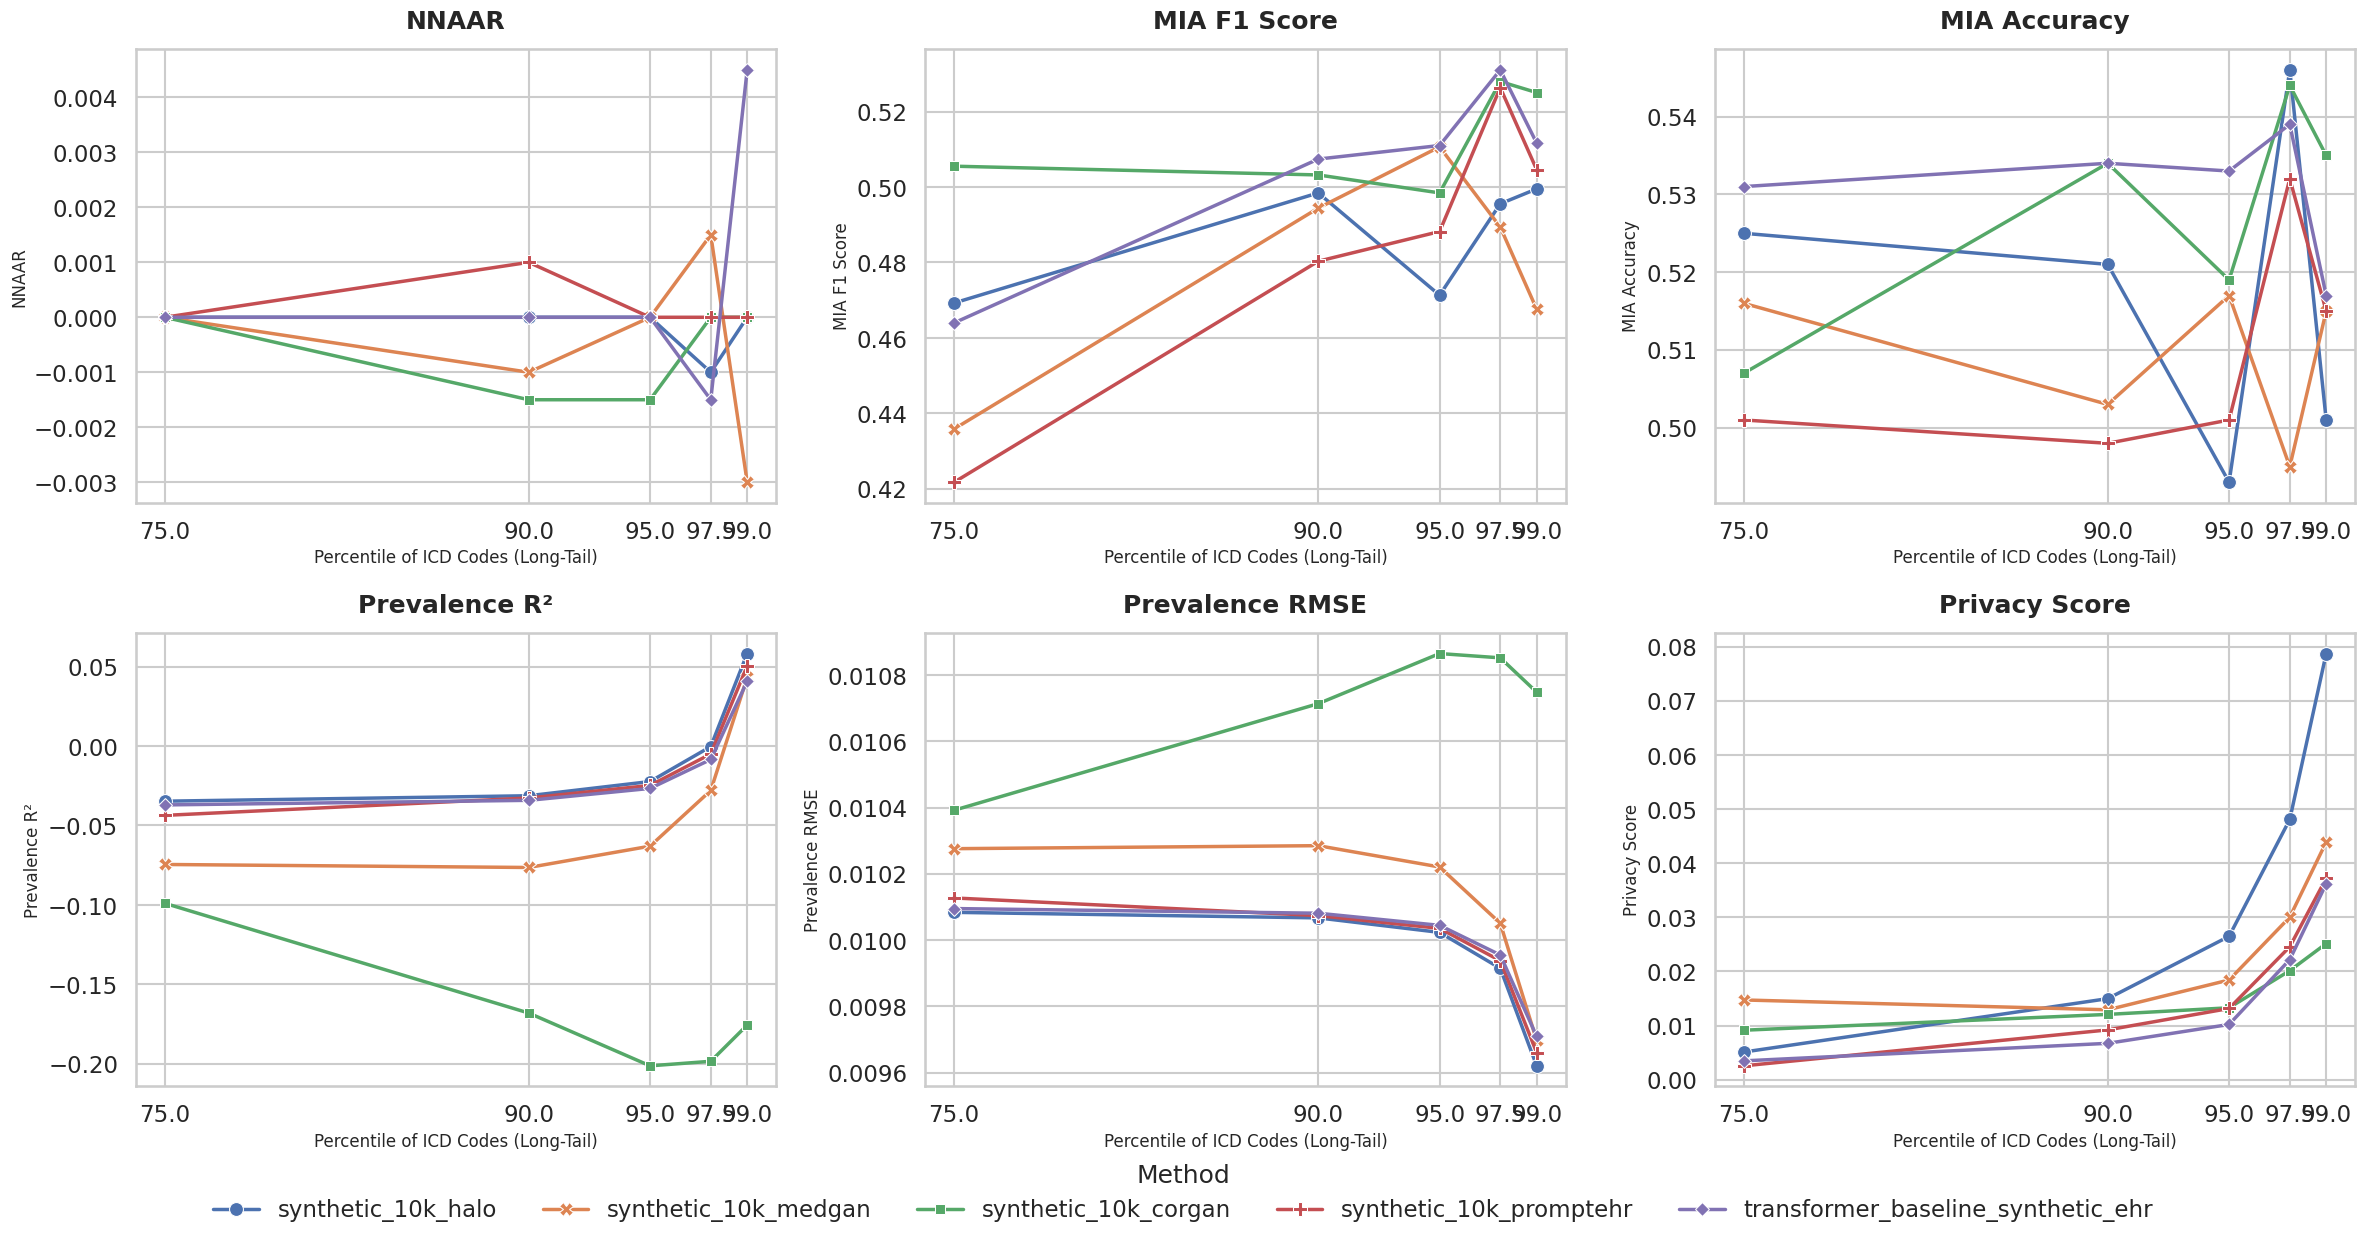

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup Data Collection
# ==========================================
all_results = []
percentiles = [75, 90, 95, 97.5, 99]

# Your existing loop, modified to collect data
for percentile in percentiles:
    try:
        # Load the CSV
        # Assuming the path is correct as per your snippet
        df = pd.read_csv(f'./imgs/{percentile}_long_tailed.csv')
        
        # Add a column for the x-axis (Percentile)
        df['Percentile'] = percentile
        
        # Append to list
        all_results.append(df)
        
        print(f"Loaded data for Bottom {percentile}% Codes")
        
    except FileNotFoundError:
        print(f"Warning: File ./imgs/{percentile}_long_tailed.csv not found.")
        # For demonstration purposes, if files are missing, 
        # you might want to break or continue.
        continue

# Combine all dataframes into one
if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
else:
    raise ValueError("No data loaded. Check file paths.")

# 2. Configuration for Plotting
# ==========================================
sns.set_theme(style="whitegrid", context="talk") # "talk" makes fonts slightly larger/readable
plt.rcParams['font.family'] = 'sans-serif'

# Map the exact column names from your CSV to pretty labels for the plot titles
metrics_map = {
    'nnaar': 'NNAAR',
    'MIA_F1': 'MIA F1 Score',
    'MIA_Accuracy': 'MIA Accuracy',
    'Prevalence_R2': 'Prevalence R²',
    'Prevalence_RMSE': 'Prevalence RMSE',
    'Privacy_Score': 'Privacy Score'
}

# Define the grid dimensions (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten() # Flatten 2D array to 1D for easy iteration

# 3. Generate Plots
# ==========================================
for i, (col_name, title) in enumerate(metrics_map.items()):
    ax = axes[i]
    
    # Check if column exists to avoid errors
    if col_name in final_df.columns:
        sns.lineplot(
            data=final_df,
            x='Percentile',
            y=col_name,
            hue='method',
            style='method',    # Different line styles for accessibility
            markers=True,      # Add dots at data points
            dashes=False,      # Solid lines (can change if desired)
            markersize=10,
            ax=ax,
            linewidth=2.5
        )
        
        # Formatting
        ax.set_title(title, fontweight='bold', pad=15)
        ax.set_xlabel("Percentile of ICD Codes (Long-Tail)", fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        
        # Set x-ticks strictly to your data points
        ax.set_xticks(percentiles)
        
        # Remove individual legends to create a shared one later
        ax.get_legend().remove()
    else:
        ax.text(0.5, 0.5, f"{col_name} not found", ha='center', va='center')

# 4. Final Layout Adjustments
# ==========================================
# Create a single shared legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.05), # Position below the plot
    ncol=len(labels),            # Horizontal legend
    frameon=False,
    title="Method"
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08) # Make room for the legend
plt.show()